In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms
import torchvision.models as models
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os

In [2]:
# Define the Dataset class
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.transform = transform
        self.image_filenames = [f for f in os.listdir(image_dir) if os.path.isfile(os.path.join(image_dir, f)) and f.endswith(('png', 'jpg', 'jpeg'))]

    # Return the length of the dataset   
    def __len__(self):
        return len(self.image_filenames)
    # Return the image at the given index
    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_filenames[idx])
        img = Image.open(img_path).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img

In [3]:
# Define the transformation
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
# Load the dataset
image_dir1 = os.path.join('anime-faces/anime-faces')
dataset1 = CustomDataset(image_dir1, transform=transform)
# Load the dataset
image_dir2 = os.path.join('faces/faces')
dataset2 = CustomDataset(image_dir2, transform=transform)

# dataset = torch.utils.data.ConcatDataset([dataset1, dataset2])

# Set the dataset as the dataset you want to use
dataset = dataset2


print(len(dataset))
# Create a dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True, pin_memory=True)
print(len(dataloader))
for i, data in enumerate(dataloader):
    print(data.shape)
    break

70171
1097
torch.Size([64, 3, 64, 64])


In [4]:
# Define the NoiseInjection
class NoiseInjection(nn.Module):
    def __init__(self, channels):
        super(NoiseInjection, self).__init__()
        self.weight = nn.Parameter(torch.zeros(1, channels, 1, 1))

    def forward(self, image):
        if self.training:
            batch, _, height, width = image.shape
            noise = image.new_empty(batch, 1, height, width).normal_()
            return image + self.weight * noise
        return image

In [5]:
# Define the ResidualBlock
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, dropout_rate=0.5):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(in_channels)
        self.relu = nn.ReLU(inplace=True)
        self.dropout1 = nn.Dropout(dropout_rate)
        self.conv2 = nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(in_channels)
        self.dropout2 = nn.Dropout(dropout_rate)
        self.noise1 = NoiseInjection(in_channels)
        self.noise2 = NoiseInjection(in_channels)
    
    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.noise1(out)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.dropout1(out)
        out = self.conv2(out)
        out = self.noise2(out)
        out = self.bn2(out)
        out = self.dropout2(out)
        out = residual + 0.3 * out
        return out

In [6]:
# Define the Generator
class UpsampleBlock(nn.Module):
    def __init__(self, in_channels, out_channels, dropout_rate=0.5):
        super(UpsampleBlock, self).__init__()
        self.upsample = nn.Upsample(scale_factor=2)
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.dropout = nn.Dropout(dropout_rate)
        self.adjust_channels = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0, bias=False)
        self.noise = NoiseInjection(out_channels)

    def forward(self, x):
        out = self.upsample(x)
        residual = self.adjust_channels(out)
        out = self.conv(out)
        out = self.noise(out)
        out = self.bn(out)
        out = self.relu(out)
        out = self.dropout(out)
        out = residual + 0.3 * out
        return out

In [7]:
# Define the ResNetGenerator
class ResNetGenerator(nn.Module):
    def __init__(self, latent_dim, img_channels, dropout_rate=0.5):
        super(ResNetGenerator, self).__init__()
        
        self.init_size = 8;
        self.l1 = nn.Sequential(nn.Linear(latent_dim, 512*self.init_size*self.init_size))
        self.noise_injection1 = NoiseInjection(512)
        
        self.residual_blocks = nn.Sequential(
            ResidualBlock(64)
        )
        
        self.upsampling_blocks = nn.Sequential(
            UpsampleBlock(512, 256, dropout_rate),
            UpsampleBlock(256, 128, dropout_rate),
            UpsampleBlock(128, 64, dropout_rate)
        )
        
        self.final_conv = nn.Conv2d(64, img_channels, kernel_size=3, stride=1, padding=1)
        self.tanh = nn.Tanh()
        
    def forward(self, z):
        out = self.l1(z)
        out = out.view(out.shape[0], 512, self.init_size, self.init_size)
        out = self.upsampling_blocks(out)
        out = self.residual_blocks(out)
        out = self.final_conv(out)
        out = self.tanh(out)
        return out

In [8]:
# Set the latent dimension and the number of channels
latent_dim = 100
img_channels = 3

In [9]:
# Define the Discriminator
resnet18 = models.resnet18(pretrained=True)
class ResNetDiscriminator(nn.Module,):
    def __init__(self, img_channels, dropout_rate=0.5):
        super(ResNetDiscriminator, self).__init__()
        self.resnet18 = models.resnet18(pretrained=True)
        self.resnet18.conv1 = nn.Conv2d(img_channels,64, kernel_size=3, stride=1, padding=1, bias=False)
        self.dropout = nn.Dropout(dropout_rate)
        self.resnet18.fc = nn.Sequential(
            nn.Linear(self.resnet18.fc.in_features, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate),
            nn.Linear(512, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate),
            nn.Linear(128, 1)
        )


    
    def forward(self, x):
        x = self.resnet18(x)
        return x

g:\anaconda\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
g:\anaconda\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [10]:
# Defining the WGAN-GP Loss Function
def generator_loss(fake_scores):
    return -torch.mean(fake_scores)

def discriminator_loss(real_scores, fake_scores, real_data, fake_data, lambda_gp):
    loss = torch.mean(fake_scores) - torch.mean(real_scores)
    # Gradient Penalty
    alpha = torch.rand(real_data.size(0), 1, 1, 1).to(device)
    interpolates = (alpha * real_data + ((1 - alpha) * fake_data)).requires_grad_(True)
    d_interpolates = discriminator(interpolates)
    fake = torch.ones(real_data.size(0), 1).to(device)
    gradients = torch.autograd.grad(outputs=d_interpolates, inputs=interpolates,
                                    grad_outputs=fake, create_graph=True, retain_graph=True, only_inputs=True)[0]
    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean() * lambda_gp
    return loss + gradient_penalty


discriminator = ResNetDiscriminator(img_channels)
# discriminator.load_state_dict(torch.load('output/discriminator_epoch_50.pth'))
discriminator.train()
generator = ResNetGenerator(latent_dim, img_channels)
# generator.load_state_dict(torch.load('output/generator_epoch_50.pth'))
generator.train()
optimizer_G = optim.Adam(generator.parameters(), lr=0.0001, betas=(0.5, 0.999), weight_decay=1e-5)
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0001, betas=(0.5, 0.999), weight_decay=1e-5)
# optimizer_G = optim.RMSprop(generator.parameters(), lr=0.0002, weight_decay=1e-5)
# optimizer_D = optim.RMSprop(discriminator.parameters(), lr=0.00002, weight_decay=1e-5)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
generator.to(device)
discriminator.to(device)


num_epochs = 300
generator_steps = 5
lambda_gp = 10 # Gradient Penalty Coefficient

output_dir = 'output'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

for epoch in range(0,num_epochs):
    for i, data in enumerate(dataloader):
        data = data.to(device)
        batch_size = data.size(0)
        
        # Create Label
        # real_labels = torch.ones(batch_size, 1) * 0.9
        # real_labels = real_labels.to(device)
        # fake_labels = torch.zeros(batch_size, 1) + 0.1
        # fake_labels = fake_labels.to(device)
        
        # ---------------------
        #  Train Discriminator
        # ---------------------
        optimizer_D.zero_grad()
        
        # Real Images Loss
        real_scores = discriminator(data)
        
        # Generate Fake Images
        z = torch.randn(batch_size, latent_dim).to(device)
        fake_images = generator(z)
        
        # Fake Images Loss
        fake_scores = discriminator(fake_images.detach())
        
        # Disciminator Total Loss
        d_loss = discriminator_loss(real_scores, fake_scores, data, fake_images, lambda_gp)
        d_loss.backward()
        optimizer_D.step()
        
        # -----------------
        #  Train Generator
        # -----------------
        for _ in range(generator_steps):
            optimizer_G.zero_grad()
            
            # Generate Loss
            z = torch.randn(batch_size, latent_dim).to(device)
            fake_images = generator(z)
            fake_scores = discriminator(fake_images)
            g_loss = generator_loss(fake_scores)
            
            g_loss.backward()
            optimizer_G.step()
        
        # Print training information
        if (i+1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(dataloader)}], D Loss: {d_loss.item():.4f}, G Loss: {g_loss.item():.4f}')
            for j in range(20):
                z = torch.randn(1, latent_dim).to(device)
                generator.eval()
                with torch.no_grad():
                    fake_image = generator(z).detach().cpu()
                generator.train()

                #Convert the image from [-1, 1] range to [0, 1] range
                fake_image = (fake_image + 1) / 2
                fake_image = fake_image.squeeze(0)  # Remove the batch dimension
                fake_image = transforms.ToPILImage()(fake_image)

                #Save the generated image
                fake_image.save(f'output/generated_image_epoch_{epoch+1}_batch_{i+1}_num_{j+1}.png')
    

    if (epoch+1) % 5 == 0:
        torch.save(generator.state_dict(), f'output/generator_epoch_{epoch+1}.pth')
        torch.save(discriminator.state_dict(), f'output/discriminator_epoch_{epoch+1}.pth')

cuda


g:\anaconda\Lib\site-packages\torch\autograd\graph.py:744: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at ..\aten\src\ATen\cuda\CublasHandlePool.cpp:135.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
g:\anaconda\Lib\site-packages\torch\autograd\graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


KeyboardInterrupt: 

In [ ]:
torch.save(generator.state_dict(), 'generator.pth')
torch.save(discriminator.state_dict(), 'discriminator.pth')

In [ ]:
generator = ResNetGenerator(latent_dim, img_channels)
generator.load_state_dict(torch.load('output/generator_epoch_35.pth'))

<All keys matched successfully>

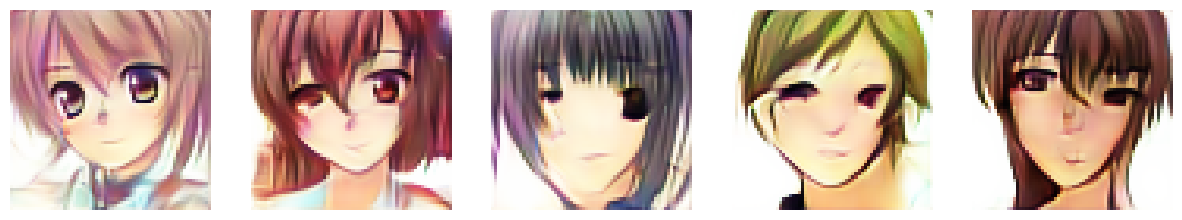

In [ ]:

generator.eval()  # Set the generator to evaluation mode

# Generate random noise vectors
num_images = 5  # Num of images to generate
latent_dim = 100  # Dimension of the latent space
z = torch.randn(num_images, latent_dim)

# Using the generator to generate images
with torch.no_grad():  # Ban the gradient calculation to speed up inference
    fake_images = generator(z)

# Convert the generated images from the [-1, 1] range to the [0, 1] range
fake_images = (fake_images + 1) / 2

# Convert to numpy array and display
fake_images = fake_images.permute(0, 2, 3, 1).cpu().numpy()  # Change the dimension order to (num_images, height, width, channels)

# Show the generated images
fig, axes = plt.subplots(1, num_images, figsize=(15, 15))
for i in range(num_images):
    axes[i].imshow(fake_images[i])
    axes[i].axis('off')
plt.show()